# Kyle Dalope


# ADS 509 Module 3: Group Comparison 

The task of comparing two groups of text is fundamental to textual analysis. There are innumerable applications: survey respondents from different segments of customers, speeches by different political parties, words used in Tweets by different constituencies, etc. In this assignment you will build code to effect comparisons between groups of text data, using the ideas learned in reading and lecture.

This assignment asks you to analyze the lyrics and Twitter descriptions for the two artists you selected in Module 1. If the results from that pull were not to your liking, you are welcome to use the zipped data from the “Assignment Materials” section. Specifically, you are asked to do the following: 

* Read in the data, normalize the text, and tokenize it. When you tokenize your Twitter descriptions, keep hashtags and emojis in your token set. 
* Calculate descriptive statistics on the two sets of lyrics and compare the results. 
* For each of the four corpora, find the words that are unique to that corpus. 
* Build word clouds for all four corpora. 

Each one of the analyses has a section dedicated to it below. Before beginning the analysis there is a section for you to read in the data and do your cleaning (tokenization and normalization). 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [21]:
import os
import re
import emoji
import pandas as pd

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud 

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer


In [22]:
# Use this space for any additional import statements you need


In [23]:
# Place any addtional functions or constants you need here. 

# Some punctuation variations
punctuation = set(punctuation) # speeds up comparison
tw_punct = punctuation - {"#"}

# Stopwords
sw = stopwords.words("english")

# Two useful regex
whitespace_pattern = re.compile(r"\s+")
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")

# It's handy to have a full set of emojis
all_language_emojis = set()

for country in emoji.EMOJI_DATA : 
    for em in emoji.EMOJI_DATA[country] : 
        all_language_emojis.add(em)

# and now our functions
def descriptive_stats(tokens, num_tokens = 5, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity, and num_tokens most common
        tokens. Return a list of 
    """

    # Place your Module 2 solution here
    num_unique_tokens = (len(set(tokens)))
    lexical_diversity = (num_unique_tokens / num_tokens) #ratio of different unique word stems (types) to the tota
    num_characters = sum(len(token) for token in tokens) #length of the string of tokens
    
    if verbose :
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
        
        # print the five most common tokens
        print(Counter(tokens).most_common(5)) #p. 16 of textbook
    
    return(0)


    
def contains_emoji(s):
    
    s = str(s)
    emojis = [ch for ch in s if emoji.is_emoji(ch)]

    return(len(emojis) > 0)


def remove_stop(tokens) :
    # modify this function to remove stopwords
    return(token for token in tokens if token.lower() not in sw)
 
def remove_punctuation(text, punct_set=tw_punct) : 
    return("".join([ch for ch in text if ch not in punct_set]))

def tokenize(text) : 
    """ Splitting on whitespace rather than the book's tokenize function. That 
        function will drop tokens like '#hashtag' or '2A', which we need for Twitter. """
    
    # modify this function to return tokens
    return(text.split())

def prepare(text, pipeline) : 
    tokens = str(text)
    
    for transform in pipeline : 
        tokens = transform(tokens)
        
    return(tokens)


## Data Ingestion

Use this section to ingest your data into the data structures you plan to use. Typically this will be a dictionary or a pandas DataFrame.

In [24]:
# Feel free to use the below cells as an example or read in the data in a way you prefer

data_location = "/Users/kyledalope/Downloads/M1 Results/"
twitter_folder = "twitter/"
lyrics_folder = os.path.join(data_location, "lyrics/")


artist_files = {'cher':'cher_followers_data.txt',
                'robyn':'robynkonichiwa_followers_data.txt'}


In [25]:
twitter_data = pd.read_csv(data_location + twitter_folder + artist_files['cher'],
                           sep="\t",
                           quoting=3)

twitter_data['artist'] = "cher"

In [26]:
twitter_data_2 = pd.read_csv(data_location + twitter_folder + artist_files['robyn'],
                             sep="\t",
                             quoting=3)
twitter_data_2['artist'] = "robyn"

twitter_data = pd.concat([
    twitter_data,twitter_data_2])
    
del(twitter_data_2)

In [27]:
# read in the lyrics here (for loops from Module 2 Assignmetn)

lyrics = {}

# For loop to the artist subfolders
for artist_sub in os.listdir(lyrics_folder):
    artist_path = os.path.join(lyrics_folder, artist_sub)
    if os.path.isdir(artist_path):
        lyrics[artist_sub] = {}

        # For loop to the songs for each artist subfolder
        for song in os.listdir(artist_path):
            song_path = os.path.join(artist_path, song)
            if os.path.isfile(song_path):
                with open(song_path, 'r') as file:
                    lyrics_content = file.read()
                    lyrics[artist_sub][song] = lyrics_content

# Create a dataframe from the lyrics dictionary
lyrics_data = pd.DataFrame([(artist, song, lyrics[artist][song]) for artist in lyrics for song in lyrics[artist]],
                           columns=['artist', 'song', 'lyrics_content'])

## Tokenization and Normalization

In this next section, tokenize and normalize your data. We recommend the following cleaning. 

**Lyrics** 

* Remove song titles
* Casefold to lowercase
* Remove stopwords (optional)
* Remove punctuation
* Split on whitespace

Removal of stopwords is up to you. Your descriptive statistic comparison will be different if you include stopwords, though TF-IDF should still find interesting features for you. Note that we remove stopwords before removing punctuation because the stopword set includes punctuation.

**Twitter Descriptions** 

* Casefold to lowercase
* Remove stopwords
* Remove punctuation other than emojis or hashtags
* Split on whitespace

Removing stopwords seems sensible for the Twitter description data. Remember to leave in emojis and hashtags, since you analyze those. 

In [28]:
#Check column names for lyrics dataframe
lyrics_data.columns

Index(['artist', 'song', 'lyrics_content'], dtype='object')

In [29]:
# apply the `pipeline` techniques from BTAP Ch 1 or 5

my_pipeline = [str.lower, remove_punctuation, tokenize, remove_stop]

lyrics_data["tokens"] = lyrics_data["lyrics_content"].apply(prepare,pipeline=my_pipeline).apply(list)
lyrics_data["num_tokens"] = lyrics_data["tokens"].apply(len) 

twitter_data["tokens"] = twitter_data["description"].apply(prepare,pipeline=my_pipeline).apply(list)
twitter_data["num_tokens"] = twitter_data["tokens"].apply(len) 


In [30]:
twitter_data['has_emoji'] = twitter_data["description"].apply(contains_emoji)

Let's take a quick look at some descriptions with emojis.

In [31]:
twitter_data[twitter_data.has_emoji].sample(10)[["artist","description","tokens"]]

,artist,description,tokens
1197453,cher,Me gusta la musica 🎶🎶🎸 Practico la guitarra🎸🎤 ...,"[gusta, la, musica, 🎶🎶🎸, practico, la, guitarr..."
1211652,cher,Se tu mismo que nadie te juzgue por lo que ere...,"[se, tu, mismo, que, nadie, te, juzgue, por, l..."
50459,robyn,Black Lives Matter. Left-handed/left-minded lo...,"[black, lives, matter, lefthandedleftminded, l..."
3623537,cher,Caution ⚠️ you are entering a Liberal Platform...,"[caution, ⚠️, entering, liberal, platform, con..."
38340,robyn,Taking a break. Stay safe friends! May Glob ab...,"[taking, break, stay, safe, friends, may, glob..."
1689218,cher,#bekind 🥀An ageless hippie with a rock and rol...,"[#bekind, 🥀an, ageless, hippie, rock, roll, he..."
444153,cher,Singer. #Gaymer. #Queer. #Latinx. Let's play! ...,"[singer, #gaymer, #queer, #latinx, lets, play,..."
2793329,cher,Agradecida con la vida. Ferviente practicante ...,"[agradecida, con, la, vida, ferviente, practic..."
3903555,cher,Little Monster 💙,"[little, monster, 💙]"
1456462,cher,I’m a nice fun loving person who loves to make...,"[i’m, nice, fun, loving, person, loves, make, ..."


With the data processed, we can now start work on the assignment questions. 

Q: What is one area of improvement to your tokenization that you could theoretically carry out? (No need to actually do it; let's not make perfect the enemy of good enough.)

A: An area of improvement for the tokenization I could theoretically carry out would include a more customized stopword removal as that was optional. This would aid to eliminate generic stopwords that would improve the relevance of the tokens by customizing the list for analysis once the goal(s) were determined initially.

sw = stopwords.words("english")

## Calculate descriptive statistics on the two sets of lyrics and compare the results. 


In [32]:
# Descriptive Stats on the lyrics_data between cher and robyn (pulled from Module 2 assignment)

# Descriptive stats on lyrics data for cher
cher_lyrics_ds = descriptive_stats([token for song in lyrics_data[lyrics_data['artist'] == 'cher']['tokens'] for token in song])

# Descriptive stats on lyrics data for robyn
robyn_lyrics_ds = descriptive_stats([token for song in lyrics_data[lyrics_data['artist'] == 'robyn']['tokens'] for token in song])

There are 5 tokens in the data.
There are 3703 unique tokens in the data.
There are 172634 characters in the data.
The lexical diversity is 740.600 in the data.
[('love', 1004), ('im', 513), ('know', 486), ('dont', 440), ('youre', 333)]
There are 5 tokens in the data.
There are 2156 unique tokens in the data.
There are 73787 characters in the data.
The lexical diversity is 431.200 in the data.
[('know', 308), ('dont', 301), ('im', 299), ('love', 275), ('got', 251)]


Q: what observations do you make about these data? 

A: With the lyrics data and observing between the two artists, cher and robyn, I observe that they both have the same number of tokens which is 5. But from there, I can distinctly notice cher contained a higher numer of unique tokens and lexical diversity; leading to a more wider variety range of vocabulary than robyn's lyrics. I did include the top five words for each and 'love' is cher's number one, while 'know' is robyn's number one. 


## Find tokens uniquely related to a corpus

Typically we would use TF-IDF to find unique tokens in documents. Unfortunately, we either have too few documents (if we view each data source as a single document) or too many (if we view each description as a separate document). In the latter case, our problem will be that descriptions tend to be short, so our matrix would be too sparse to support analysis. 

To avoid these problems, we will create a custom statistic to identify words that are uniquely related to each corpus. The idea is to find words that occur often in one corpus and infrequently in the other(s). Since corpora can be of different lengths, we will focus on the _concentration_ of tokens within a corpus. "Concentration" is simply the count of the token divided by the total corpus length. For instance, if a corpus had length 100,000 and a word appeared 1,000 times, then the concentration would be $\frac{1000}{100000} = 0.01$. If the same token had a concentration of $0.005$ in another corpus, then the concentration ratio would be $\frac{0.01}{0.005} = 2$. Very rare words can easily create infinite ratios, so you will also add a cutoff to your code so that a token must appear at least $n$ times for you to return it. 

An example of these calculations can be found in [this spreadsheet](https://docs.google.com/spreadsheets/d/1P87fkyslJhqXFnfYezNYrDrXp_GS8gwSATsZymv-9ms). Please don't hesitate to ask questions if this is confusing. 

In this section find 10 tokens for each of your four corpora that meet the following criteria: 

1. The token appears at least `n` times in all corpora
1. The tokens are in the top 10 for the highest ratio of appearances in a given corpora vs appearances in other corpora.

You will choose a cutoff for yourself based on the side of the corpus you're working with. If you're working with the Robyn-Cher corpora provided, `n=5` seems to perform reasonably well.

In [33]:
robyn_tw_descs = twitter_data[twitter_data.artist=="robyn"].tokens.to_list()
robyn_tw_descs = [item for sublist in robyn_tw_descs for item in sublist]

In [35]:
robyn_tw_ct = Counter(robyn_tw_descs)
robyn_tw_ct

Counter({'love': 11615,
         'chill': 120,
         '•facebook': 2,
         'instagram': 2444,
         'soundcloud': 151,
         'angelxoarts•': 1,
         'httpstco447okklkza…': 1,
         'books': 936,
         'movies': 943,
         'music': 14858,
         'nature': 499,
         'tv': 1669,
         'shows': 306,
         'og': 2026,
         'sweetee': 1,
         'since': 1216,
         '12': 318,
         'thanks': 231,
         'youtube': 742,
         'recommending': 2,
         'feeling': 153,
         'homepage': 17,
         '♥️': 76,
         'amauteur': 1,
         'en': 4833,
         'herbe': 2,
         '🌱': 166,
         'juriste': 2,
         'paille': 1,
         '🤡': 25,
         'ami': 10,
         'des': 178,
         'fleurs': 3,
         '🌸🌈': 1,
         'sans': 30,
         'la': 3217,
         'main': 149,
         'verte': 15,
         '#morecomingsoon': 1,
         'si': 378,
         'voit': 5,
         'le': 417,
         'bout': 53,
        

In [36]:
def get_top_tokens(counter,reference_counters,allowed_tokens,top_n=10) :
    """
        Given a counter and a set of allowable tokens, get the top_n tokens
        for the counter and print them. "Top" here is defined as having the 
        maximum ratio of presence in a given counter compared to the sum of the
        other counters. 
    """
    
    comparison = Counter()
    results = defaultdict(float)
    
    for ct in reference_counters :
        comparison += ct
        
    for token, count in counter.items() : 
        if token in allowed_tokens : 
            results[token] = count/comparison[token]
    
    # found this nifty trick here: https://stackoverflow.com/questions/11902665/top-values-from-dictionary
    results = sorted([(k,v) for k, v in results.items()],key=lambda x: x[1])[-top_n:]
    
    return(results)

#def get_word_frac(word, fd_corpus, length):

    if word in fd_corpus:
        return(fd_corpus[word]/length)
    else:
        return(0)
    
#def get_ratio(word, fd_corpus_1, fd_corpus_2, len_1, len_2):
    #frac_1 = get_word_frac(word, fd_corpus_1, len_1)
    #frac_2 = get_word_frac(word, fd_corpus_2, len_2)

    #if frac_2 > 0:
        #return(frac_1/frac_2)
   else:
       # return(float('NaN'))

#def compare_texts(corpus_1, corpus_2, num_words = 10, ratio_cutoff=5):

    results = dict()

    #Get first part with a function
    results["one"] = get_patterns(corpus_1, num_words)
    results["two"] = get_patterns(corpus_2, num_words)

    #Ratio and frequency dist
    corpus_1 = token_normal(corpus_1)
    corpus_2 = token_normal(corpus_2)

    fd_1 = FreqDist(corpus_1)
    fd_2 = FreqDist(corpus_2)

    #Set of words in each corpus
    fd_1_words = set(fd_1.keys())
    fd_2_words = set(fd_2.keys())

    #Hold the ratios 
    holder = dict()

    #diciontary for results
    results["one_vs_two"] = dict()
    results["two_vs_one"] = dict()

    for word, count in fd_1.items():
        if count > ratio_cutoff:
            if word in fd_2_words and fd_2[word] > ratio_cutoff:
                holder[word] = get_ratio(word, fd_1, fd_2,
                                         results["one"]["tokens"],
                                         results["two"]["tokens"])
    
    num_added = 0 

    for word, frac in sorted(holder.items(), key=lambda item: -1*item[1]):
        results["one_vs_two"][word] = frac
        num_added += 1
        if num_added == num_words:
            break

    return(results)

compare_texts(" ".join(lyrics_data)," ".join(twitter_data), num_words=5)

Q: What are some observations about the top tokens? Do you notice any interesting items on the list? 

A: 

## Build word clouds for all four corpora. 

For building wordclouds, we'll follow exactly the code of the text. The code in this section can be found [here](https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/ch01/First_Insights.ipynb). If you haven't already, you should absolutely clone the repository that accompanies the book. 


In [20]:
from matplotlib import pyplot as plt

def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    
    
def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

In [38]:
cher_tw_count = count_words(twitter_data[twitter_data['artist']=="cher"])
cher_tw_count

,freq
token,
nan,1994031
love,213522
im,139051
life,122679
music,86733
...,...
#funkopops,2
‘hey,2
#letustalk,2


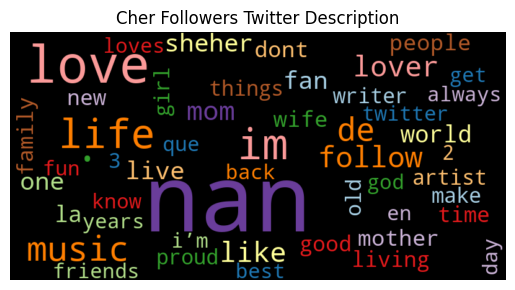

In [39]:
wordcloud(cher_tw_count['freq'], title="Cher Followers Twitter Description", max_words=50, stopwords=None)

Q: What observations do you have about these (relatively straightforward) wordclouds? 

A: After running the code chunk for wordcloud and was not able to return the results to make the observations.

# References

pandas.Series.apply — pandas 2.0.2 documentation. (n.d.). Pandas.pydata.org. Retrieved May 30, 2023, from https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.apply.html

‌Pandas Apply Tutorial for Python DataFrames. (n.d.). Www.datacamp.com. https://www.datacamp.com/tutorial/pandas-apply

Albrecht, J., Ramachandran, S., & Winkler, C. (2020). Blueprints for text analytics using Python. O'Reilly.
‌